<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_tasa_dilucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de la tasa de dilución en el biorreactor continuo mediante el método del descenso del gradiente

Autor: Juan Manuel Gutiérrez García 

Fecha: enero 2021

# Descripción del problema de optimización de la tasa de dilución en el biorreactor continuo

En un biorreactor continuo que es operado bajo condiciones de estado estacionario es importante estudiar el efecto de la tasa de dilución, $D$, sobre la productividad de biomasa y producto. 

En la presente sección se llevan a cabo simulaciones para responde a la pregunta de qué valor de la tasa de dilución, $D$, permite generar la máxima productividad de biomasa y etanol. Estas simulaciones se realizan para cada una de las cinco levaduras estudiadas en la sección anterior. Para llevar a cabo las simulaciones se emplean los parámetros cinéticos obtenidos mediante el ajuste del modelo de Monod a los datos experimentales de las levaduras. Finalmente, se compara la productividad de biomasa y etanol obtenida con cada levadura. 

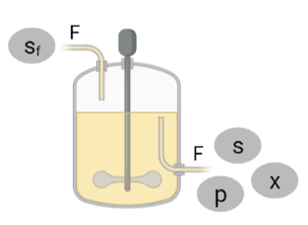

Figura 1. Esquema del biorreactor continuo para la optimización de la tasa de dilución.

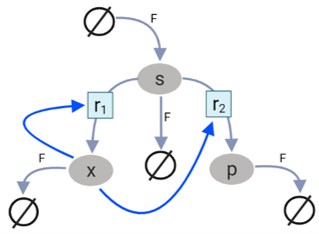

Figura 2. Red para describir el proceso del biorreactor continuo. Aquí se observan las reacciones y los flujos de materia (flechas grises), así como las especies que intervienen en estas reacciones. Además, es posible apreciar el efecto positivo de la biomasa sobre la generación de etanol y su propia producción (flechas azules).

# Modelo matemático para la optimización de la tasa de dilución

En un biorreactor continuo la productividad de biomasa se define como la concentración de biomasa que sale del biorreactor por unidad de tiempo. Dado que se asumen condiciones estacionarias, la productividad de biomasa se puede expresar de la siguiente manera

\begin{equation}
    P_x(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})
    \tag{1}
\end{equation}


De forma similar, la productividad de etanol en condiciones de estado estacionario se expresa como

\begin{equation}
    P_e(D) = D Y_{px}Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})
    \tag{2}
\end{equation}

Dado que el interés es obtener la máxima productividad de biomasa y etanol en condiciones de estado estacionario, las funciones (1) y (2) constituyen las funciones objetivo.

In [1]:
#@title establecer función objetivo 
# aquí x representa la variable a optimizar, osea D 
productivity_func <- function(x, p) {
  with(as.list(p), {

    productivity_x = x*Yxs*(sf - x*ks/(mu_max - x))
    productivity_p = Ypx*productivity_x
    return(list(productivity_x = productivity_x, productivity_p = productivity_p))

  })
}

In [5]:
# valor arbitrario de parámetros
p <- c(mu_max = 1.2, ks = 180, Yxs = 0.1, Ypx = 2,sf = 80, D = 0.01)
# valores de D a evaluar
x <- 0.1

In [6]:
# obtener productividad
productivity <- productivity_func(x,p)
print(productivity)

$productivity_x
[1] 0.6363636

$productivity_p
[1] 1.272727



En realidad, las dos funciones objetivo son equivalentes ya que una es un múltiplo de la otra. Por esta razón, ambas poseen el mismo valor óptimo de la tasa de dilución, de tal manera que basta con optimizar cualquiera de ellas para conocer el valor de la tasa de dilución que genere la mayor productividad de biomasa y etanol. En lo siguiente se emplea (1) para la optimización.

Considerando lo anterior, el problema de optimización se enuncia como sigue 

Maximizar: 

\begin{equation}
    P_x(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D}) \tag{1}
\end{equation}

Sujeto a: 

\begin{equation}
    0 < D < D^{*}
    \tag{3}
\end{equation}

El límite superior en (3) se obtuvo a partir del análisis de estabilidad realizado. Por esta razón es importante llevar a cabo una análisis de estabilidad antes de determinar las condiciones óptimas de operación.

Para encontrar el óptimo de (1) se empleó el método del gradiente. Para poder aplicar este método se requiere obtener primero la derivada de (1) con respecto a $D$.

\begin{equation}
    \frac{dP_x(D)}{dD} = Y_{xs}\left[ s_f - k_s D \left( \frac{2 \mu_{max} - D}{(\mu_{max} - D)^2} \right) \right]
    \tag{4}
\end{equation}

In [7]:
# @title derivada de la función de productividad 
deriv_productivity_func <- function(x, p) {
    with(as.list(p),{
        df = Yxs*(sf - ks*x*((2*mu_max - x)/(mu_max-x)^2))
        return(df)
    })
}

In [8]:
deriv_productivity_func(x = 0.43, p = p)

[1] -17.71732

Una vez que se tiene la derivada (gradiente para una función de una sola variable) se puede usar el siguiente algoritmo para obtener la tasa de dilución óptima, $D^{opt}$.

## Método del gradiente

In [9]:
#@title método de ascenso del gradiente 
gradient_method <- function(x0,alpha,eps,p) {
    grad = deriv_productivity_func(x0,p)
    while(abs(grad) > eps) {
        x = x0 + alpha*grad # sumar porque se busca subir por la colina
        x0 = x
        grad = deriv_productivity_func(x0,p)
    }
    return(list(sol = x, grad = grad))
}

In [10]:
x0 <- 0.05
alpha <- 0.01
eps <- 0.01
sol <- gradient_method(x0, alpha, eps, p)
productivity_opt <- productivity_func(sol$sol, p)

In [11]:
print(sol)
print(productivity_opt)

$sol
[1] 0.2013876

$grad
[1] 0.007918772

$productivity_x
[1] 0.880061

$productivity_p
[1] 1.760122



In [12]:
# cargar librerías
library(ggplot2)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [13]:
#@title función para generar datos con productividad
get_data_productivity <- function(productivity) {
    # guardar resultados 
    out <- data.frame(D = rep(x,2), productivity = c(productivity$productivity_x, 
                                    productivity$productivity_p), 
                                    var = rep(factor(c("x","p")), each = length(x)))
    return(out)
}

In [14]:
out <- get_data_productivity(productivity)
head(out)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.1,0.6363636,x
2,0.1,1.2727273,p


In [15]:
#@title función para graficas la productividad
plot_productivity <- function(out) {
    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    ylab("Productividad de biomasa (g/L h)") +
    xlab("D (1/h)") +
    scale_color_discrete(name = "", labels = c("etanol", "biomasa")) +
    theme_bw() +
    theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=20,   ),
            legend.position = c(0.80, 0.80), 
            legend.background = element_rect(fill=NA))
            
}

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



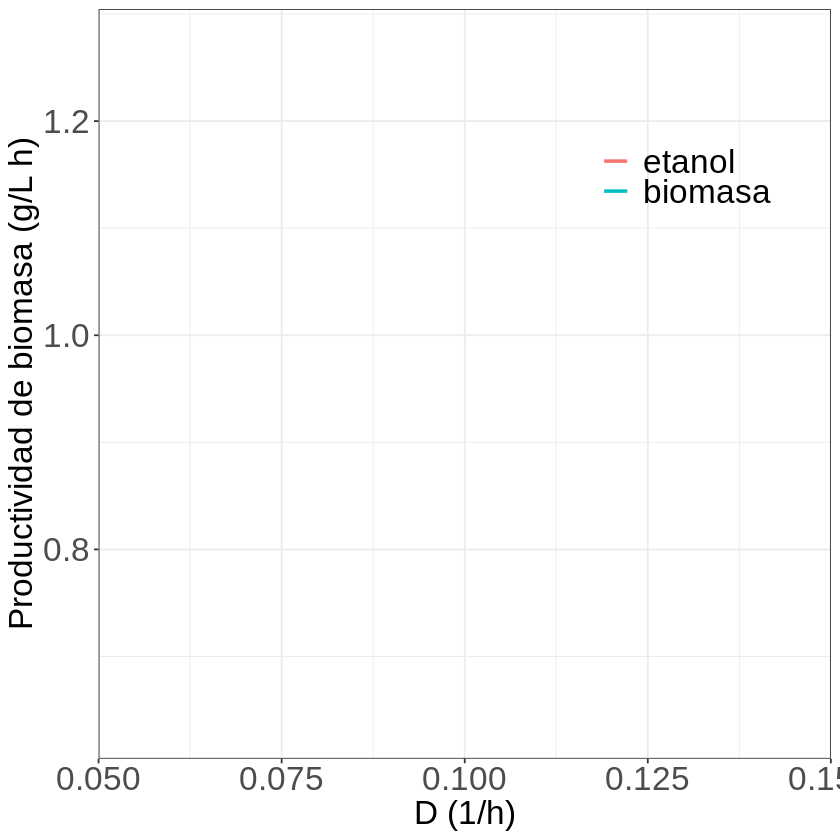

In [16]:
plot_productivity(out)

In [17]:
#@title función para graficar productividad con tasa de alimentación óptima
plot_productivity_Dopt <- function(out, sol, productivity) {
    # mostrar resultados 
    optima = data.frame(D = rep(sol$sol,2),
    productivity = c(productivity$productivity_x,productivity$productivity_p))

    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    geom_vline(xintercept = sol$sol, color = "skyblue", lwd = 2, lty = 2) +
    geom_point(data = optima, col = "brown", cex = 5) +
    ylab("Productividad de biomasa (g/Lh)") +
    xlab("D (1/h)") +
    scale_color_discrete(name = "", labels = c("etanol", "biomasa")) +
    theme_bw() +
    theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=20,   ),
            legend.position = c(0.80, 0.80), 
            legend.background = element_rect(fill=NA))
}

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



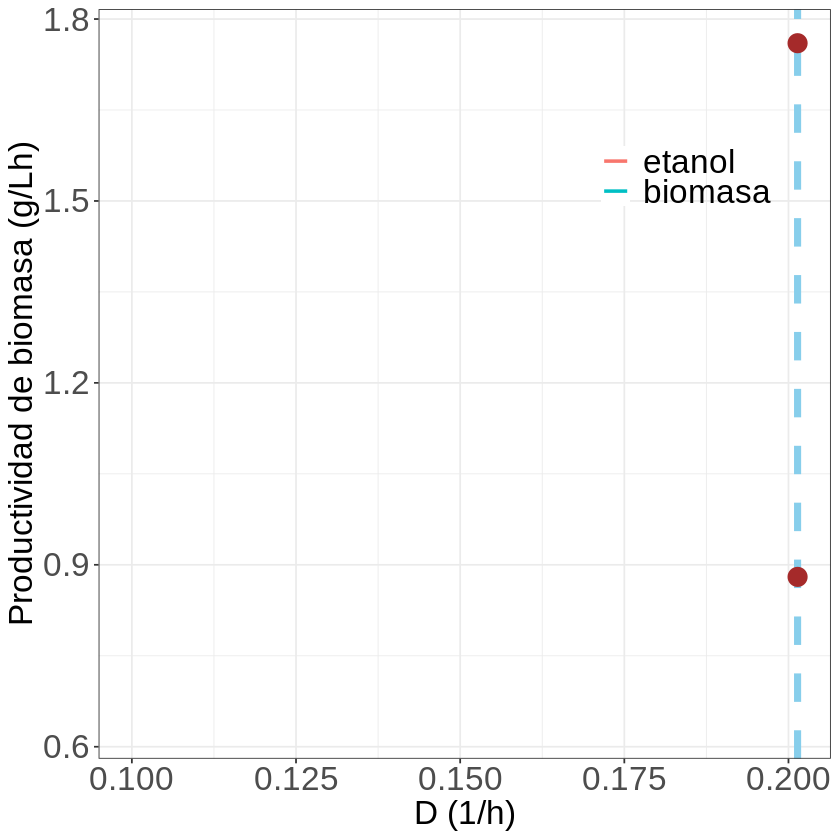

In [18]:
plot_productivity_Dopt(out,sol, productivity_opt)

### Valor límite para $D$

In [ ]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {

    D = mu_max*sf/(ks + sf)

    return(D)
  })
}

# Optimización con parámetros de *Isstchenkia terrícola*

Debemos proponer un valor para el parámetros $s_f$. Establezcamos $s_f = 80\ g/L$

In [ ]:
# parámetros óptimos de Isstchenkia terrícola
p_it <- c(mu_max = 1.4536067, ks = 284.3997206, Yxs = 0.1092001, Ypx = 7.0414839, sf = 80)

In [ ]:
# obtener productividad
productivity_it <- productivity_func(x,p_it)

# generar los datos para la gráfica
out_it <- get_data_productivity(productivity_it)
head(out_it)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02192415,x
3,0.005050505,0.04357438,x
4,0.007575758,0.06494927,x
5,0.010101010,0.08604736,x
6,0.012626263,0.10686721,x


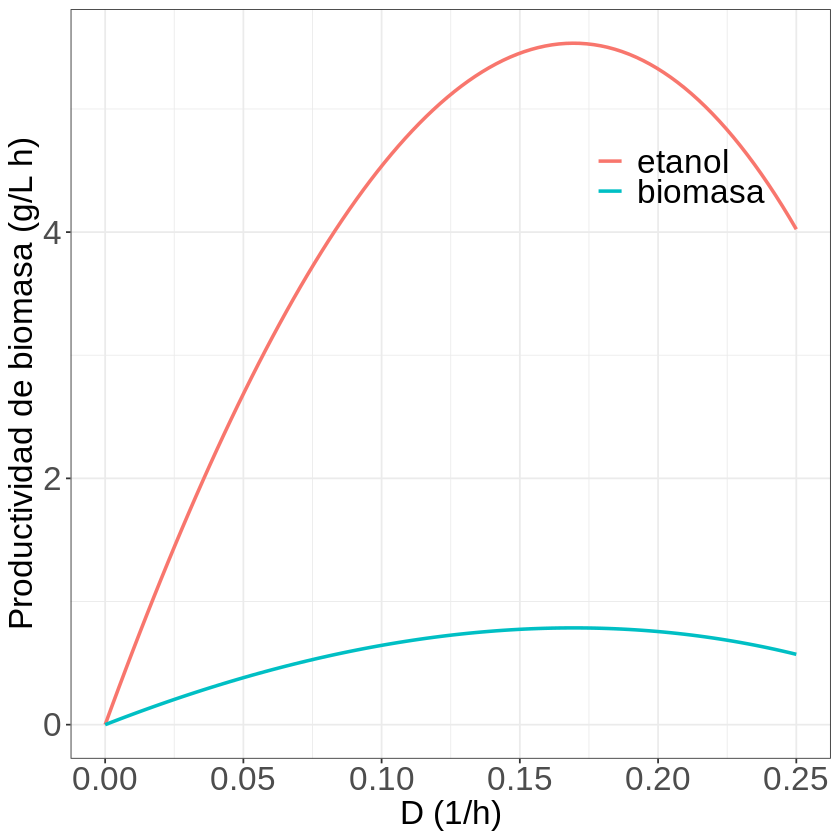

In [ ]:
plot_productivity(out_it)

### Realizar optimización 

In [ ]:
sol_it <- gradient_method(x0, alpha, eps, p_it)
productivity_opt_it <- productivity_func(sol_it$sol, p_it)

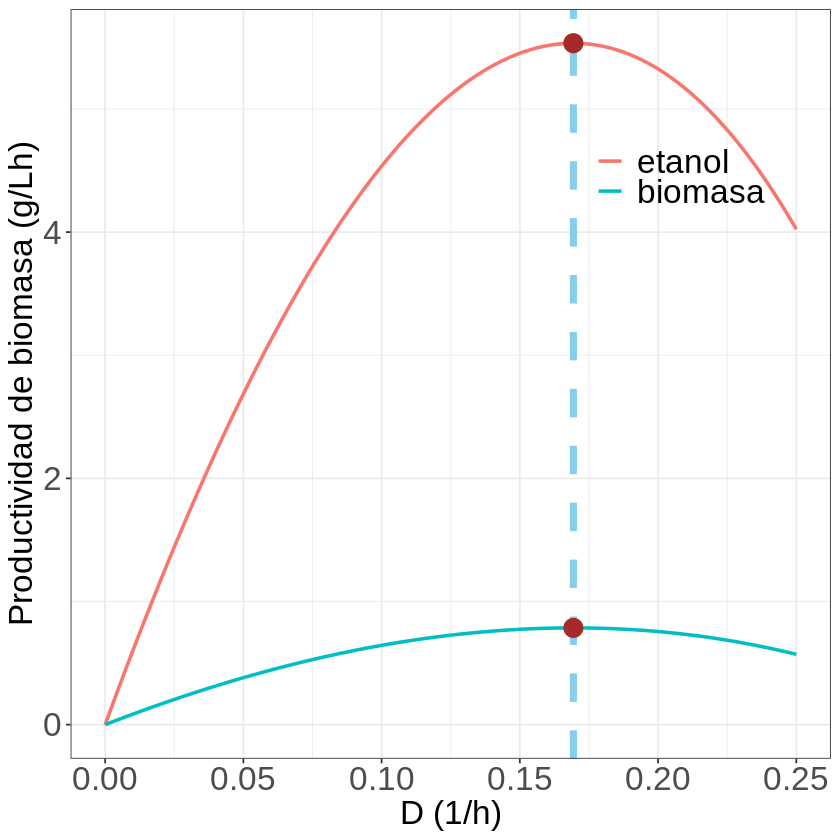

In [ ]:
plot_productivity_Dopt(out_it,sol_it, productivity_opt_it)

# Optimización con parámetros de *Kluyveromyces marxianus*

In [ ]:
# parámetros óptimo para Kluyveromyces marxianus
p_km <- c(mu_max = 1.0110607, ks = 353.3425303, Yxs = 0.1301708, Ypx = 4.9448320, sf = 80)      

In [ ]:
D_bif(p_km)

[1] 0.1866534

In [ ]:
# obtener productividad
productivity_km <- productivity_func(x,p_km)

# generar los datos para la gráfica
out_km <- get_data_productivity(productivity_km)
head(out_km)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02600631,x
3,0.005050505,0.05142805,x
4,0.007575758,0.07626082,x
5,0.010101010,0.10050015,x
6,0.012626263,0.12414154,x


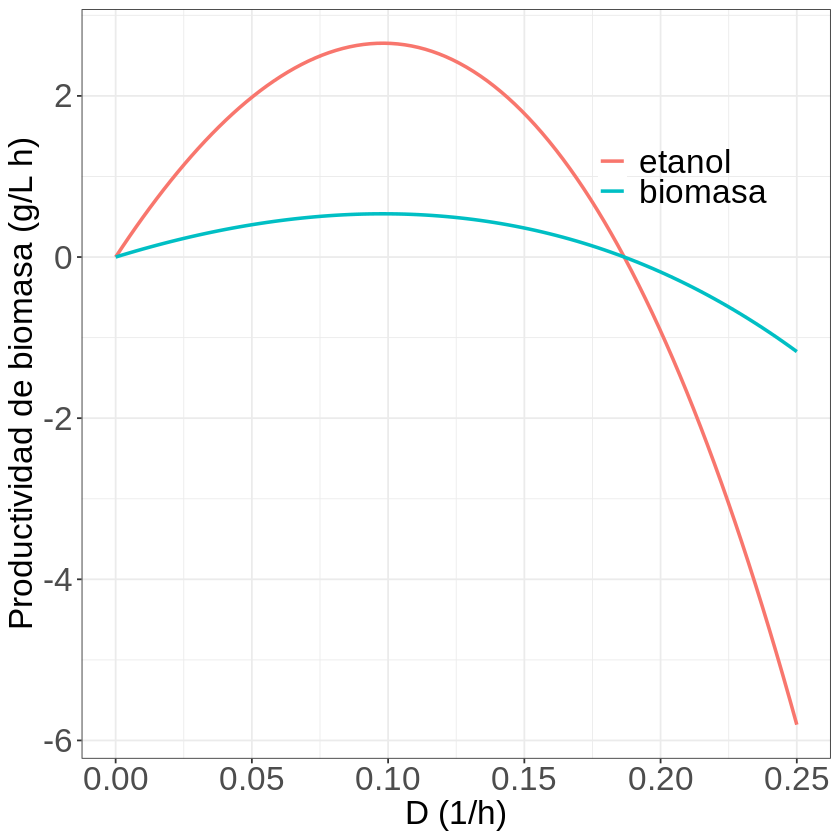

In [ ]:
plot_productivity(out_km)

### Realizar optimización 

In [ ]:
sol_km <- gradient_method(x0, alpha, eps, p_km)
productivity_opt_km <- productivity_func(sol_km$sol, p_km)

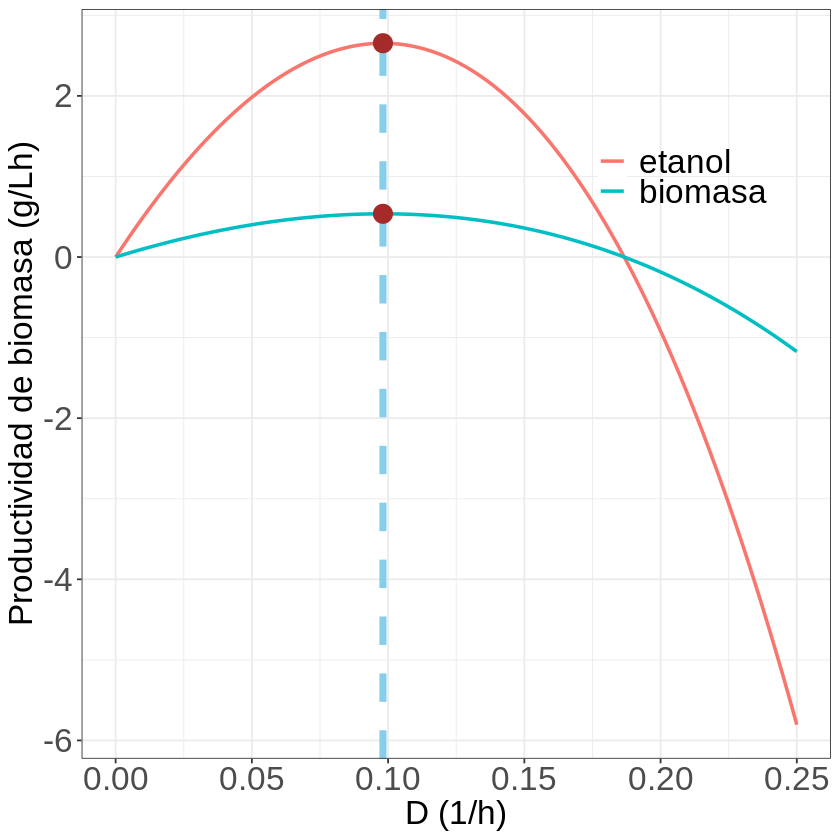

In [ ]:
plot_productivity_Dopt(out_km, sol_km,productivity_opt_km)

# Optimización con parámetros de *Pichia kluyveri*

In [ ]:
# parámetros óptimos de Pichia kluyveri
p_pk <- c(mu_max = 0.6588448, ks = 366.8216124, Yxs = 0.1032014, Ypx = 3.8650679, sf = 80)  

In [ ]:
D_bif(p_pk)

[1] 0.1179611

In [ ]:
# obtener productividad
productivity_pk <- productivity_func(x,p_pk)

# generar los datos para la gráfica
out_pk <- get_data_productivity(productivity_pk)
head(out_pk)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02048095,x
3,0.005050505,0.04022057,x
4,0.007575758,0.05921026,x
5,0.010101010,0.07744123,x
6,0.012626263,0.09490462,x


### Realizar optimización 

In [ ]:
sol_pk <- gradient_method(x0,alpha,eps,p_pk)
productivity_opt_pk <- productivity_func(sol_pk$sol, p_pk)

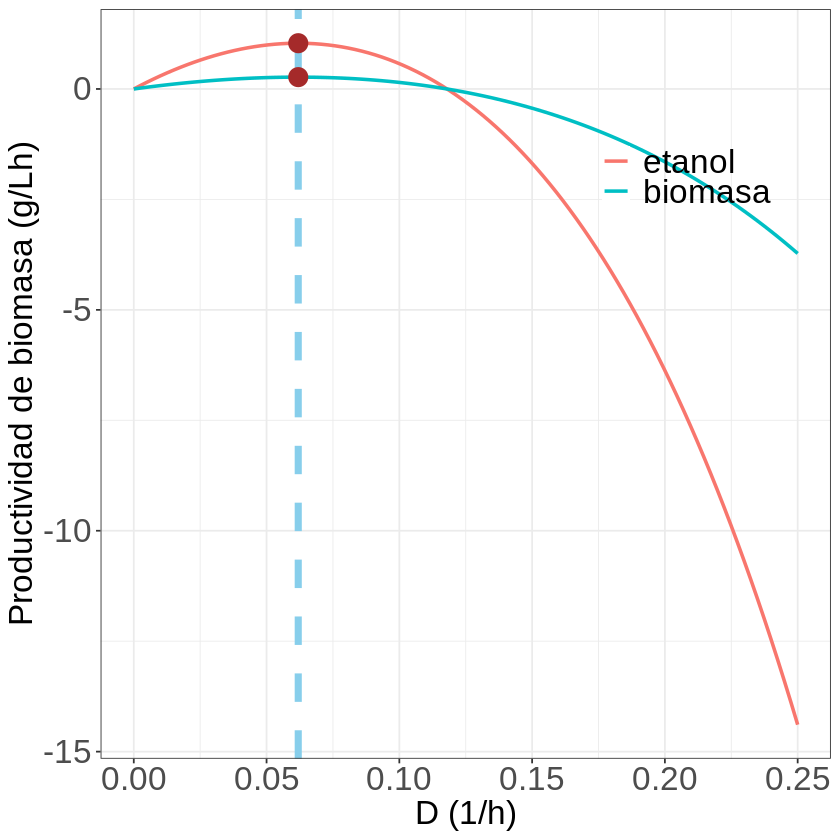

In [ ]:
plot_productivity_Dopt(out_pk, sol_pk,productivity_opt_pk)

# Optimización con parámetros de *Zygosaccharomyces bailii*

In [ ]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zb <- c(mu_max = 1.1682471, ks = 300.1541664, Yxs = 0.1171282, Ypx = 4.9301197, sf = 80)  

In [ ]:
D_bif(p_zb)

[1] 0.245847

In [ ]:
# obtener productividad
productivity_zb <- productivity_func(x,p_zb)

# generar los datos para la gráfica
out_zb <- get_data_productivity(productivity_zb)
head(out_zb)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02346994,x
3,0.005050505,0.04655358,x
4,0.007575758,0.06924839,x
5,0.010101010,0.09155183,x
6,0.012626263,0.11346133,x


### Realizar optimización 

In [ ]:
sol_zb <- gradient_method(x0, alpha, eps, p_zb)
productivity_opt_zb <- productivity_func(sol_zb$sol, p_zb)

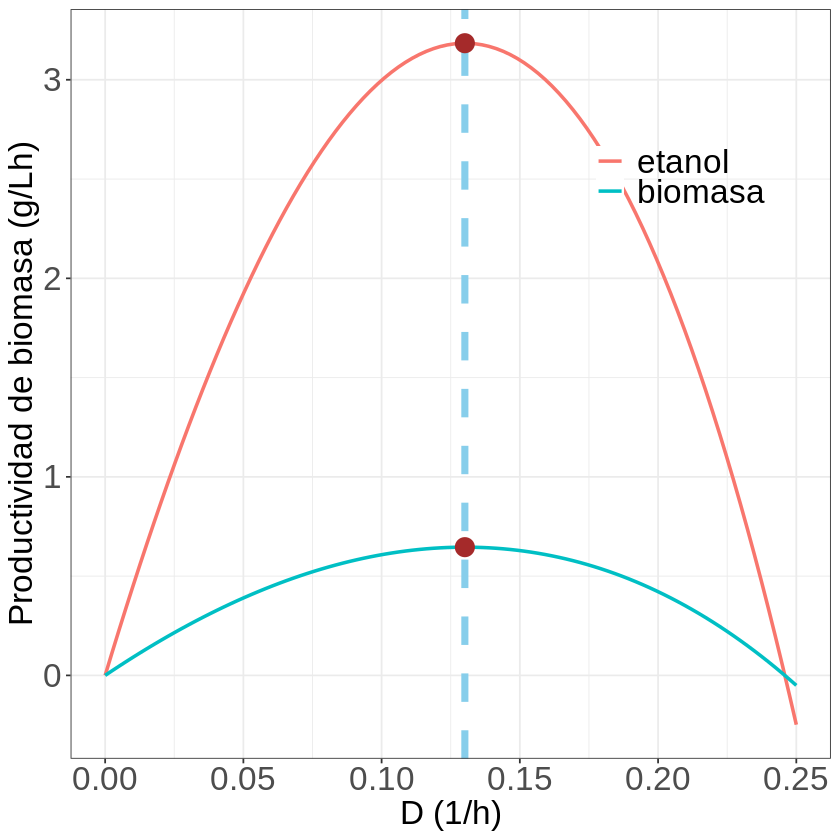

In [ ]:
plot_productivity_Dopt(out_zb, sol_zb, productivity_opt_zb)

# Optimización con parámetros de *Zigosaccharomyces rouxi*

In [ ]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zr <- c(mu_max = 0.5003527, ks = 250.9052285, Yxs = 0.1950366, Ypx = 3.1550382, sf = 80) 

In [ ]:
D_bif(p_zr)

[1] 0.1209658

In [ ]:
# obtener productividad
productivity_zr <- productivity_func(x, p_zr)

# generar datos para la gráfica
out_zr <- get_data_productivity(productivity = productivity_zr)
head(out_zr)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.03877449,x
3,0.005050505,0.07628252,x
4,0.007575758,0.11250462,x
5,0.010101010,0.14742091,x
6,0.012626263,0.18101112,x


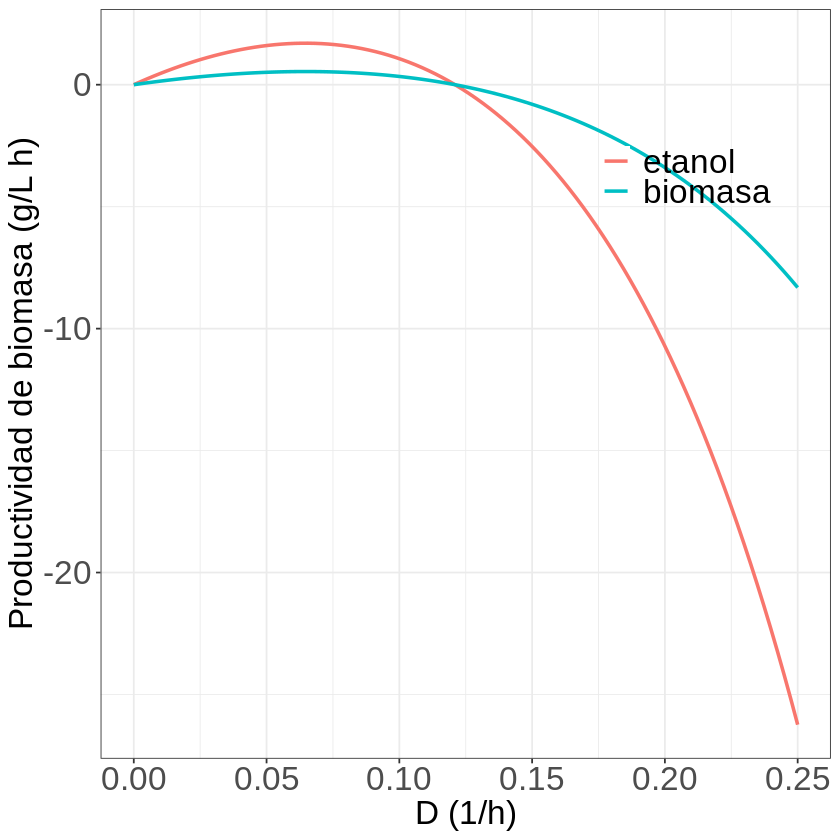

In [ ]:
plot_productivity(out_zr)

### Realizar optimización 

In [ ]:
sol_zr <- gradient_method(x0, alpha, 0.1, p_zr)
productivity_opt_zr <- productivity_func(sol_zr$sol, p_zr)

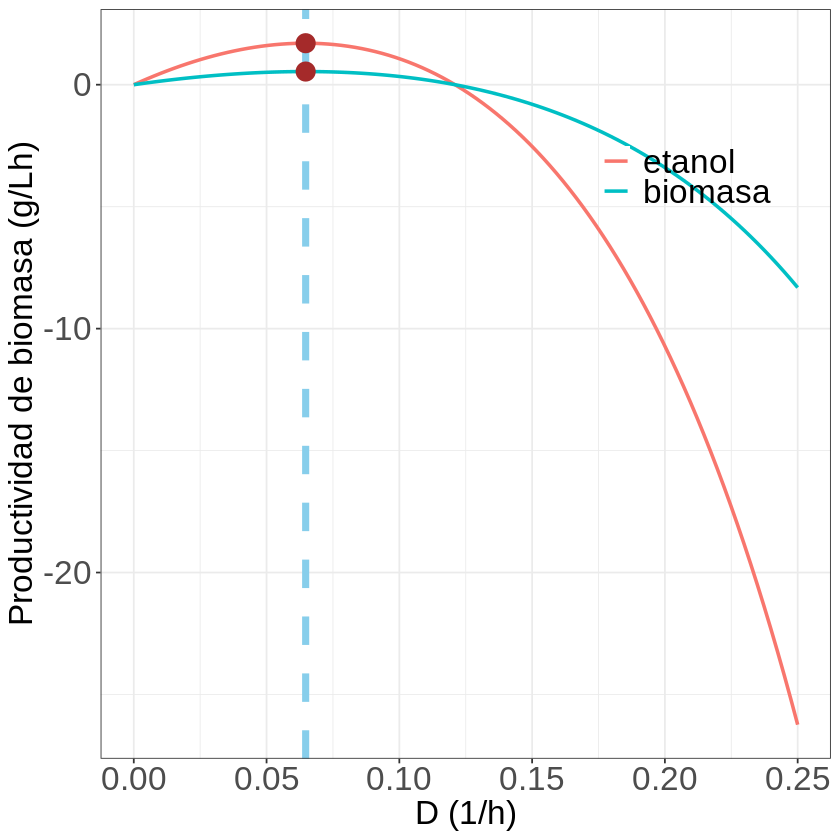

In [ ]:
plot_productivity_Dopt(out_zr, sol_zr,productivity_opt_zr)

# Resultados 

Tabla 1. Valores de $D^{opt}$, $\dot{m}_x$ y $\dot{m}_p$ obtenido para las diferentes levaduras 

| levadura | $D^{opt}$ | $D^{*}$ | $\dot{m}_x$ | $\dot{m}_p$ |
|:---:|:---:|:---:|:---:|:---:|
| Isstchenkia terrícola | $0.169\ h^{-1}$ | $0.319\ h^{-1}$ |$0.785\ g/h$ | $5.5339\ g/h$ |
| Kluyveromyces marxianus | $0.0981\ h^{-1}$ |$0.1866\ h^{-1}$  |$0.536\ g/h$ |$2.654\ g/h$ |
| Pichia kluyveri | $0.0619\ h^{-1}$ |$0.117\ h^{-1}$  |$0.268\ g/h$ |$1.036\ g/h$ |
| Zygosaccharomyces bailii | $0.130\ h^{-1}$ |$0.245\ h^{-1}$  |$0.645\ g/h$ |$3.184\ g/h$ |
| Zigosaccharomyces rouxi |$0.0647\ h^{-1}$ |$0.120
\ h^{-1}$  |$0.539\ g/h$ |$1.7015\ g/h$ |

In [ ]:
# @title D límite
cat("Isstchenkia terrícola \n")
cat("D_opt:", D_bif(p_it), "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", D_bif(p_km), "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", D_bif(p_pk), "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", D_bif(p_zb), "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", D_bif(p_zr), "(1/h)")

Isstchenkia terrícola 
D_opt: 0.3191236 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.1866534 (1/h) 

Pichia kluyveri 
D_opt: 0.1179611 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.245847 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.1209658 (1/h)

In [ ]:
#@title mp máximo 
cat("Isstchenkia terrícola \n")
cat("mp_max: ", productivity_opt_it$productivity_p, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mp_max: ", productivity_opt_km$productivity_p, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mp_max: ", productivity_opt_pk$productivity_p, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mp_max: ", productivity_opt_zb$productivity_p, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mp_max: ", productivity_opt_zr$productivity_p, "g/Lh")

Isstchenkia terrícola 
mp_max:  5.533932 g/Lh 

Kluyveromyces marxianus 
mp_max:  2.654108 g/Lh 

Pichia kluyveri 
mp_max:  1.036084 g/Lh 

Zygosaccharomyces bailii 
mp_max:  3.184248 g/Lh 

Zigosaccharomyces rouxi 
mp_max:  1.701502 g/Lh

In [ ]:
#@title D óptimos 
cat("Isstchenkia terrícola \n")
cat("D_opt:", sol_it$sol, "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", sol_km$sol, "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", sol_pk$sol, "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", sol_zb$sol, "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", sol_zr$sol, "(1/h)")

Isstchenkia terrícola 
D_opt: 0.169363 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.09810681 (1/h) 

Pichia kluyveri 
D_opt: 0.0619346 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.1301124 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.06472541 (1/h)

In [ ]:
#@title mx máximo 
cat("Isstchenkia terrícola \n")
cat("mx_max: ", productivity_opt_it$productivity_x, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mx_max: ", productivity_opt_km$productivity_x, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mx_max: ", productivity_opt_pk$productivity_x, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mx_max: ", productivity_opt_zb$productivity_x, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mx_max: ", productivity_opt_zr$productivity_x, "g/Lh")

Isstchenkia terrícola 
mx_max:  0.7859042 g/Lh 

Kluyveromyces marxianus 
mx_max:  0.5367438 g/Lh 

Pichia kluyveri 
mx_max:  0.2680636 g/Lh 

Zygosaccharomyces bailii 
mx_max:  0.6458765 g/Lh 

Zigosaccharomyces rouxi 
mx_max:  0.5392968 g/Lh

### Gráfica de barras con tasas de dilución óptimas 

In [ ]:
data_Dopt <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    Dopt = c(sol_it$sol,sol_km$sol,sol_pk$sol,sol_zb$sol,sol_zr$sol))

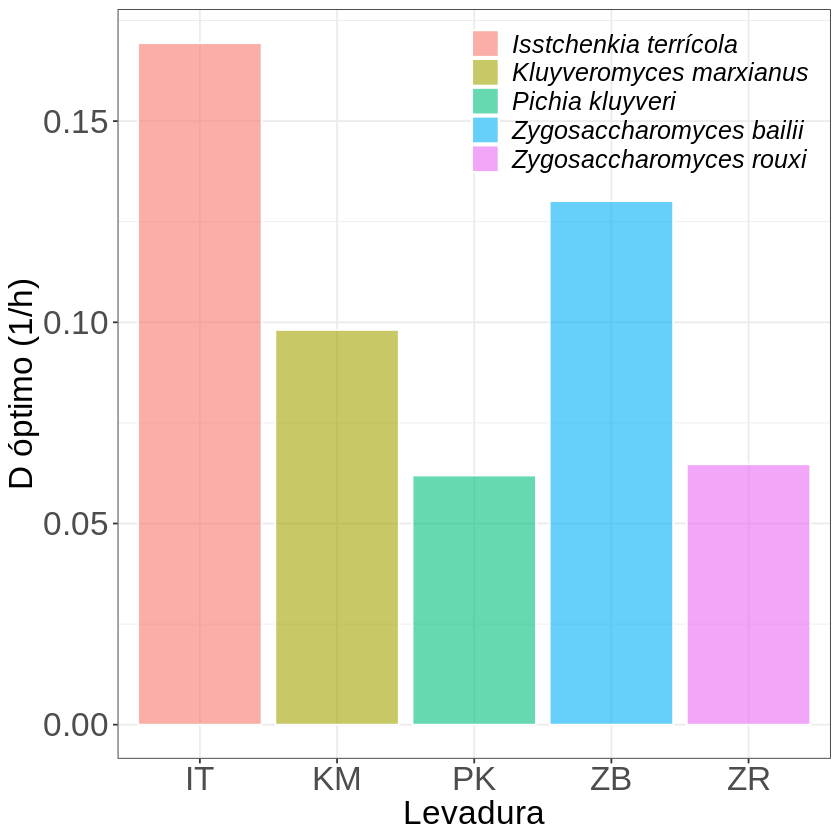

In [ ]:
ggplot(data=data_Dopt, aes(x=lev, y=Dopt, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("D óptimo (1/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

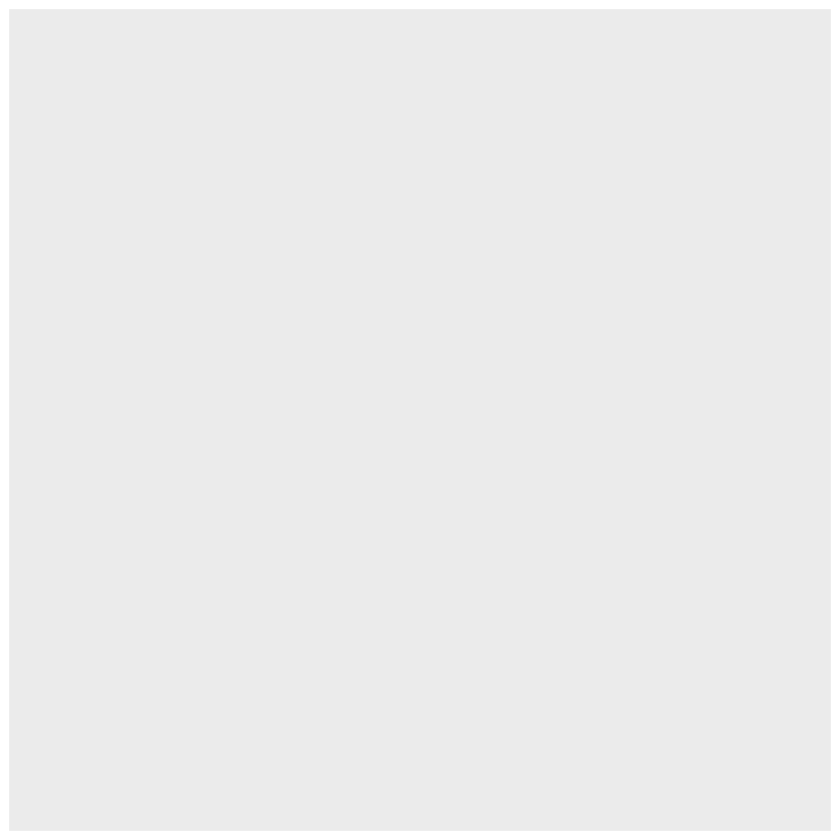

In [ ]:
ggplot(data = out_it, aes(x = ))

### Gráfica de barras para la producción de biomasa 

In [ ]:
data_mx <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(productivity_opt_it$productivity_x,productivity_opt_km$productivity_x,
                           productivity_opt_pk$productivity_x,productivity_opt_zb$productivity_x,
                           productivity_opt_zr$productivity_x))

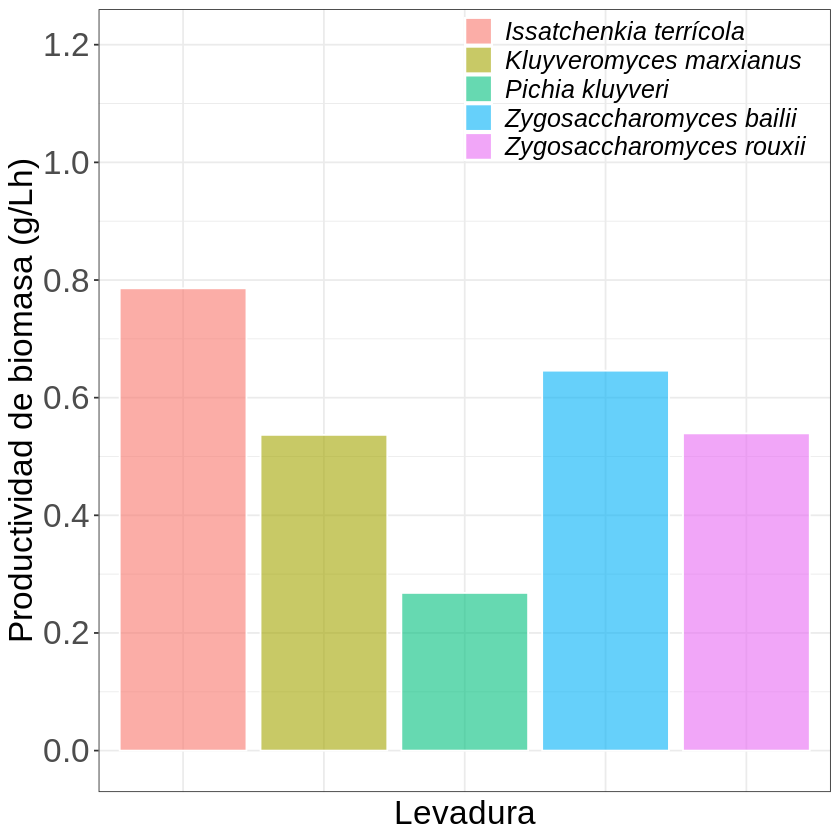

In [ ]:
ggplot(data=data_mx, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Productividad de biomasa (g/Lh)") +
  scale_y_continuous(limits = c(-0.01, 1.2), breaks = seq(0,1.2,0.2)) +
  scale_fill_discrete(name = "", labels = c("Issatchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxii")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráfica de barras para la producción de etanol

In [ ]:
data_mp <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mp = c(productivity_opt_it$productivity_p,productivity_opt_km$productivity_p,
                           productivity_opt_pk$productivity_p,productivity_opt_zb$productivity_p,
                           productivity_opt_zr$productivity_p))

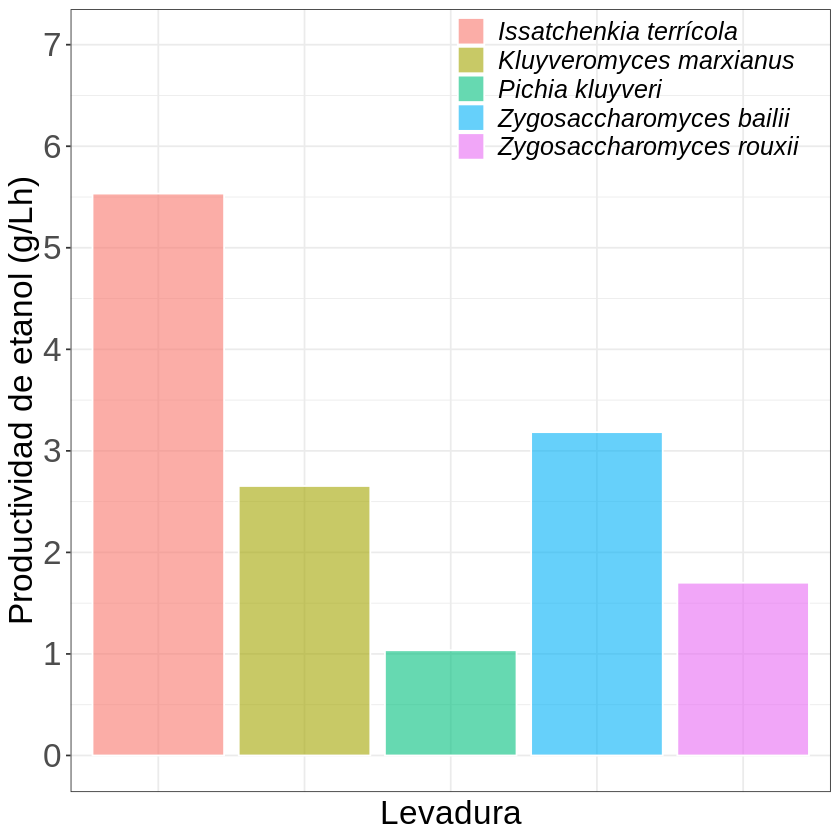

In [ ]:
ggplot(data=data_mp, aes(x=lev, y=mp, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Productividad de etanol (g/Lh)") +
  scale_y_continuous(limits = c(-0.01, 7), breaks = seq(0,7,1)) +
  scale_fill_discrete(name = "", labels = c("Issatchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxii")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráficas de productividad contra D

In [ ]:
data_productivity_x <- data.frame(D = rep(x,5), productivity_x = c(productivity_it$productivity_x,productivity_km$productivity_x,
                            productivity_pk$productivity_x,productivity_zb$productivity_x,productivity_zr$productivity_x), 
                            lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(x)))

Warning message:
“Removed 130 row(s) containing missing values (geom_path).”


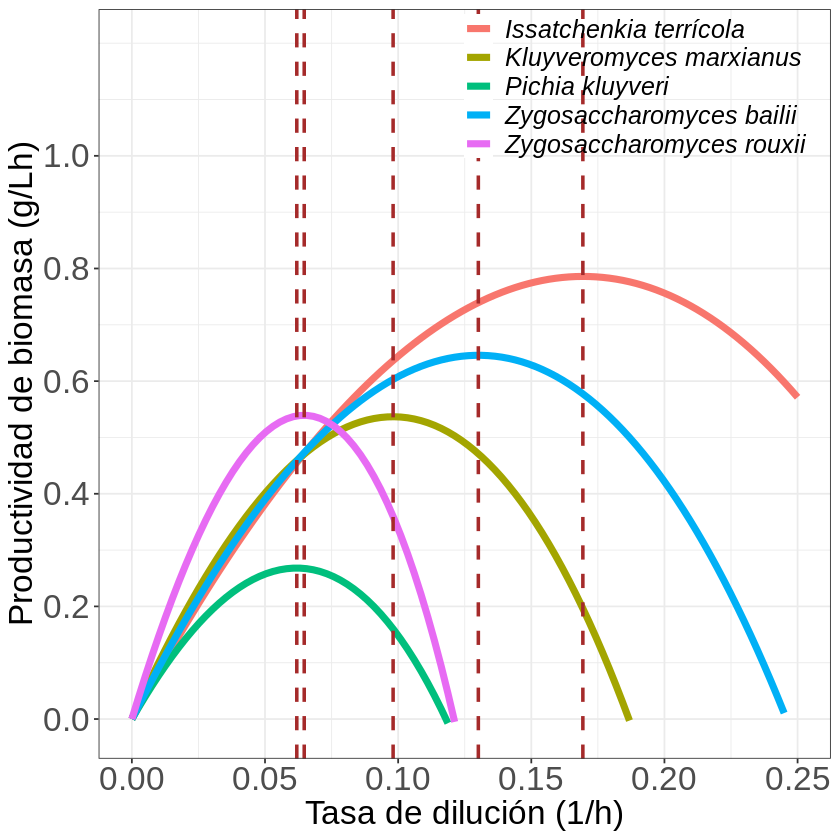

In [ ]:
ggplot(data = data_productivity_x, aes(x = D, y = productivity_x, color = lev)) +
        geom_line(lwd = 2) +
        geom_vline(xintercept = sol_it$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_km$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_pk$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zb$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zr$sol, col = "brown", lwd = 1, lty = 2) +
        xlab("Tasa de dilución (1/h)") +
        ylab("Productividad de biomasa (g/Lh)") +
        theme_bw() +
        xlim(c(0,0.25))+
        scale_y_continuous(limits = c(-0.01, 1.2), breaks = seq(0,1,0.2)) +
        scale_color_discrete(labels=c("Issatchenkia terrícola", 
        "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
        "Zygosaccharomyces rouxii"))+
        theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))

In [ ]:
data_productivity_p <- data.frame(D = rep(x,5), productivity_p = c(productivity_it$productivity_p,productivity_km$productivity_p,
                            productivity_pk$productivity_p,productivity_zb$productivity_p,productivity_zr$productivity_p), 
                            lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(x)))

Warning message:
“Removed 133 row(s) containing missing values (geom_path).”


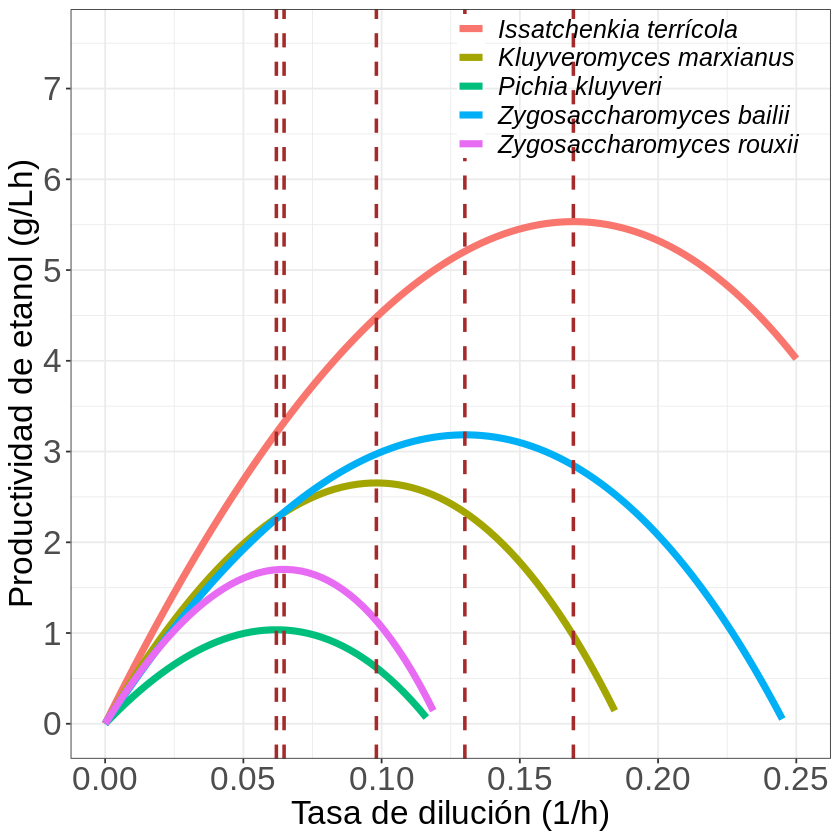

In [ ]:
ggplot(data = data_productivity_p, aes(x = D, y = productivity_p, color = lev)) +
        geom_line(lwd = 2) +
        geom_vline(xintercept = sol_it$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_km$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_pk$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zb$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zr$sol, col = "brown", lwd = 1, lty = 2) +
        xlab("Tasa de dilución (1/h)") +
        ylab("Productividad de etanol (g/Lh)") +
        theme_bw() +
        xlim(c(0,0.25))+
        scale_y_continuous(limits = c(-0.01, 7.5), breaks = seq(0,7,1)) +
        scale_color_discrete(labels=c("Issatchenkia terrícola", 
        "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
        "Zygosaccharomyces rouxii"))+
        theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))

In [ ]:
deriv_productivity_func(sol_it$sol, p_it)

[1] 0.004577044

In [ ]:
sol_it$grad

[1] 0.004577044

In [ ]:
f_x <- function(x) {
    f = x[1]^2 + x[1]*x[2] + 10*x[2]^2 - 5*x[1] - 3*x[2]
    return(f)
}

In [ ]:
df_x <- function(x) {
    return(c(2*x[1] + x[2] - 5, x[1] + 20*x[2] - 3))
}

In [ ]:
gradient_descent <- function(x0,alpha, N) {

    X = matrix(nrow = N, ncol = 2)
    i = 1
    grad = df_x(x0)
    while(i <= N) {
        x = x0 - alpha*grad
        X[i,] = x
        x0 = x
        grad = df_x(x0)
        i = i + 1
    }
    return(list(sol = X, grad = grad))
}

In [ ]:
x0 = c(-3,-1)
alpha = 0.085
N = 100
sol3 = gradient_descent(x0, alpha, N)

In [ ]:
sol3

-1.9800000,1.21000000
-1.3212500,-0.42370000
-0.6356230,0.66389625
-0.1589983,-0.15569942
0.3062659,0.37750445
0.6471128,-0.03528571
0.9651029,0.22469541
1.2069363,0.01567946
1.4254244,0.14143479
1.5960803,0.03483458
1.7467857,0.09494897


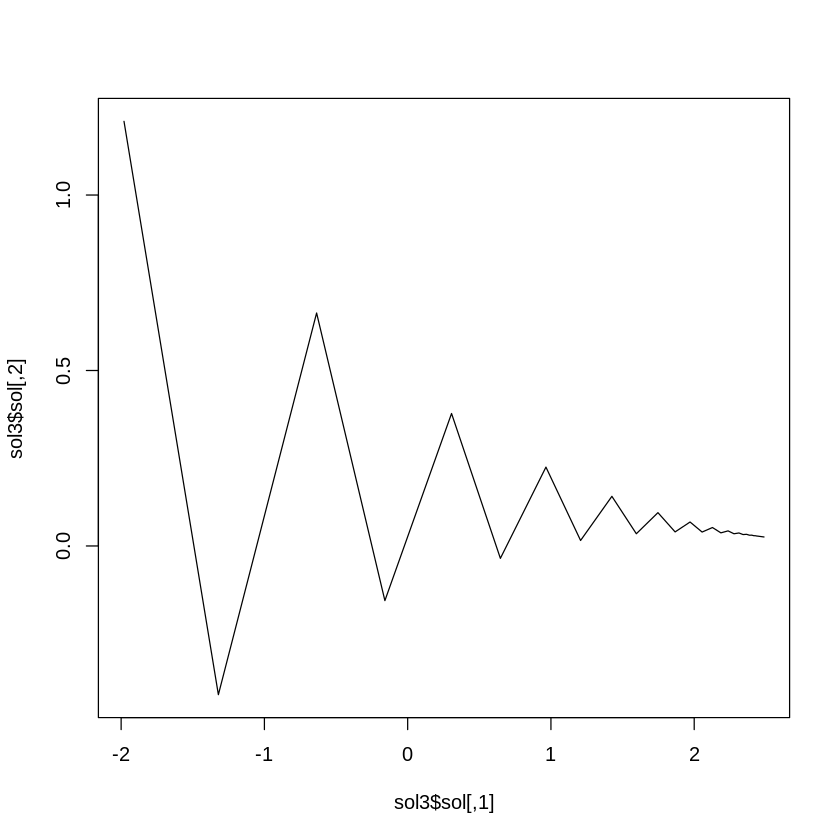

In [ ]:
plot(sol3$sol, type = "l")